## 1. Amount out min B

In [67]:
def calculate_amount_out(reserve_in, reserve_out, amount_in, fee_in, fee_out):
    return (1-fee_out)* amount_in * (1-fee_in) * reserve_out / (reserve_in + amount_in * (1-fee_in))

In [68]:
def calculate_amount_in(reserve_in, reserve_out, amount_out, fee_in, fee_out):
    amount_in = (reserve_in * amount_out) / ((1 - fee_out) * (reserve_out - amount_out))
    amount_in = amount_in / (1 - fee_in)
    return amount_in

In [79]:
def final_amount_out(amount_in, reserves, fees):
    for i in range(len(reserves)):
        if amount_in > reserves[i][0]:
            amount_in = 0
        amount_in = calculate_amount_out(amount_in=amount_in, reserve_in=reserves[i][0], reserve_out=reserves[i][1], fee_in=fees[i][0], fee_out=fees[i][1])
    return amount_in

In [70]:
def amount_out_min_b(amount_out, reserves, fees):
    for i in range(len(reserves)-1, 0 ,-1):
        amount_out = calculate_amount_in(amount_out=amount_out, reserve_in=reserves[i][0], reserve_out=reserves[i][1], fee_in=fees[i][0], fee_out=fees[i][1])
    return amount_out

In [72]:
reserves = [(74626029623859, 291617730009247), (24705057451478, 3411298623683584), (412570925264561, 812516930576)]
fees = [(0.003, 0.003), (0.003, 0.003), (0.003, 0.003)]

amount_in = 10 * 10**9
p = 1.1
amount_out_required = amount_in * p
amount_in = amount_out_min_b(amount_out_required, reserves, fees)

# skip first hop
reserves = [(24705057451478, 3411298623683584), (412570925264561, 812516930576)]
fees = [(0.003, 0.003), (0.003, 0.003)]

final_amount_out(amount_in, reserves, fees)

10999497397.254694

# 2. Optimal trade volume

In [73]:
import numpy as np
reserves = [(74626029623859, 291617730009247), (24705057451478, 3411298623683584), (412570925264561, 812516930576)]
fees = [(0.003, 0.003), (0.003, 0.003), (0.003, 0.003)]

In [80]:
lower_bound = 10* 10**9
upper_bound = 100 * 10**9


amount_ins = np.linspace(lower_bound, upper_bound, 100)

In [81]:
amount_outs = []
for amount_in in amount_ins:
    amount_out = final_amount_out(amount_in, reserves, fees)
    amount_outs.append(amount_out)

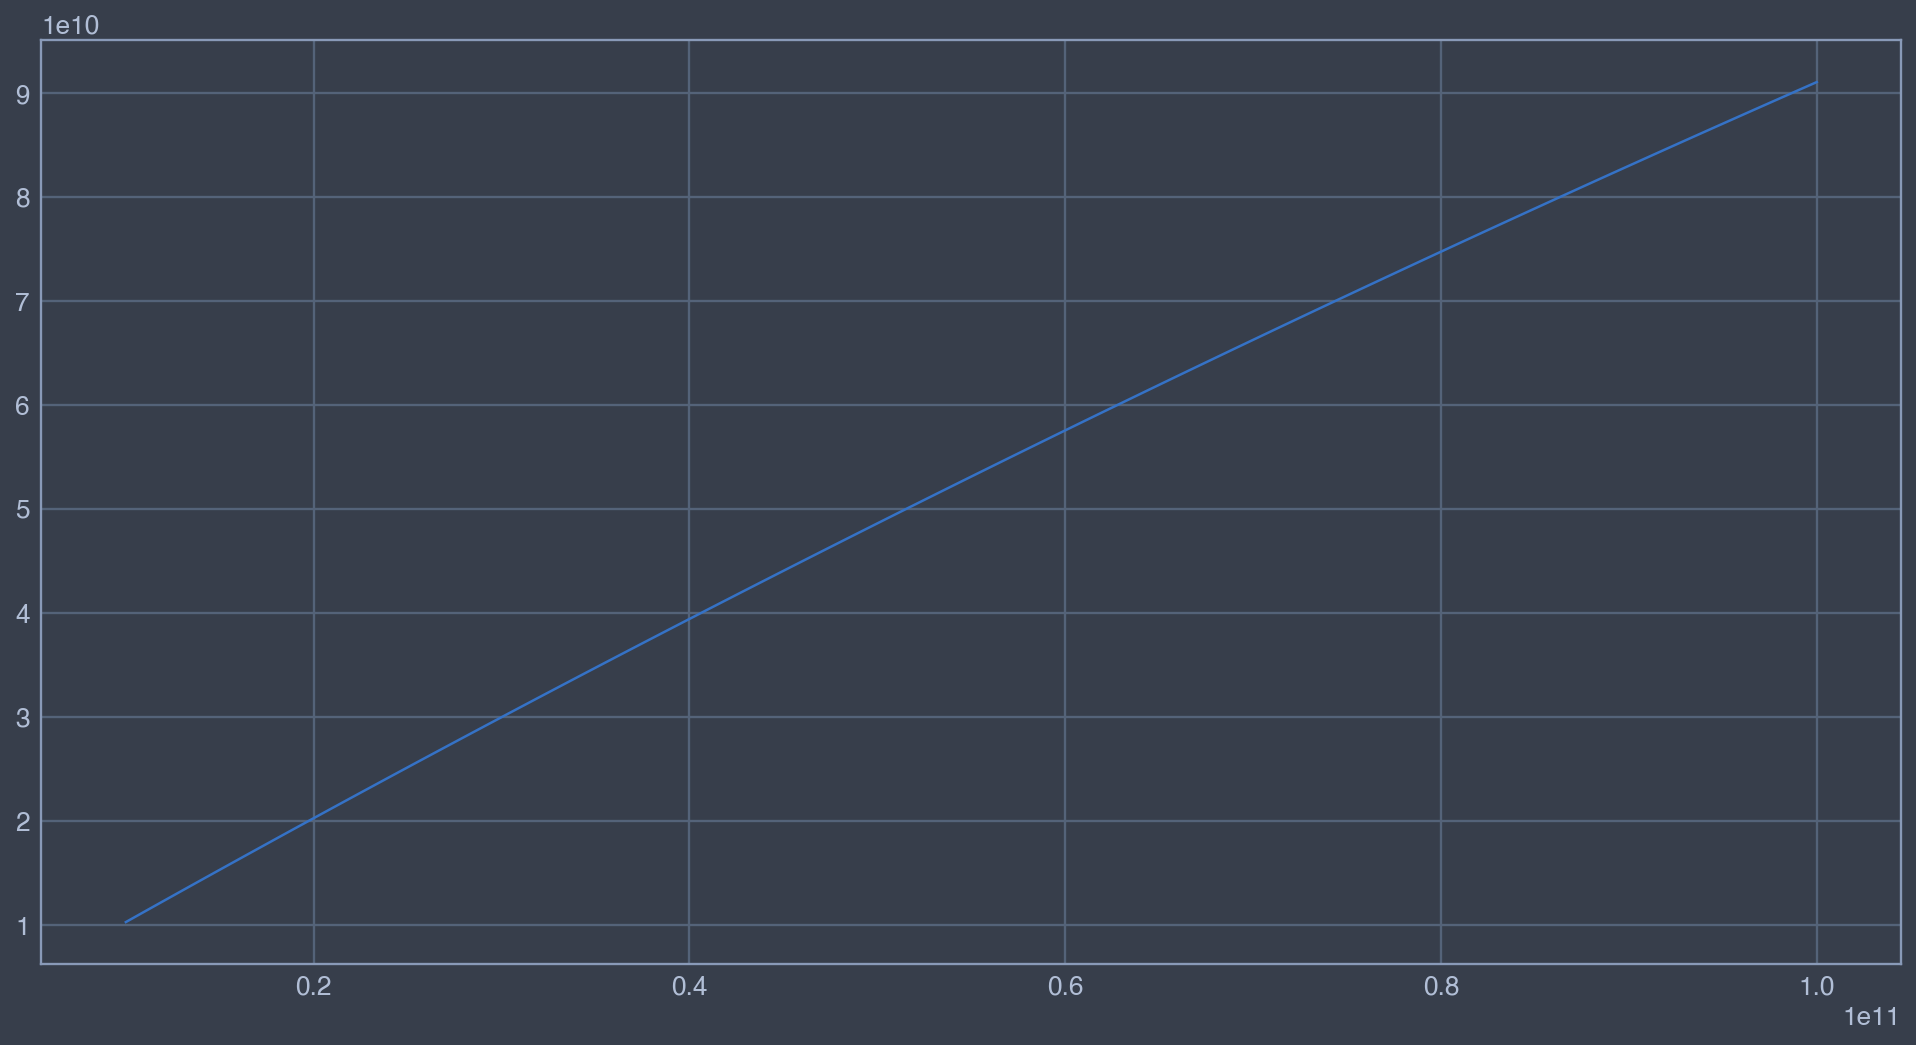

In [88]:
import matplotlib.pyplot as plt
plt.plot(amount_ins, amount_outs)

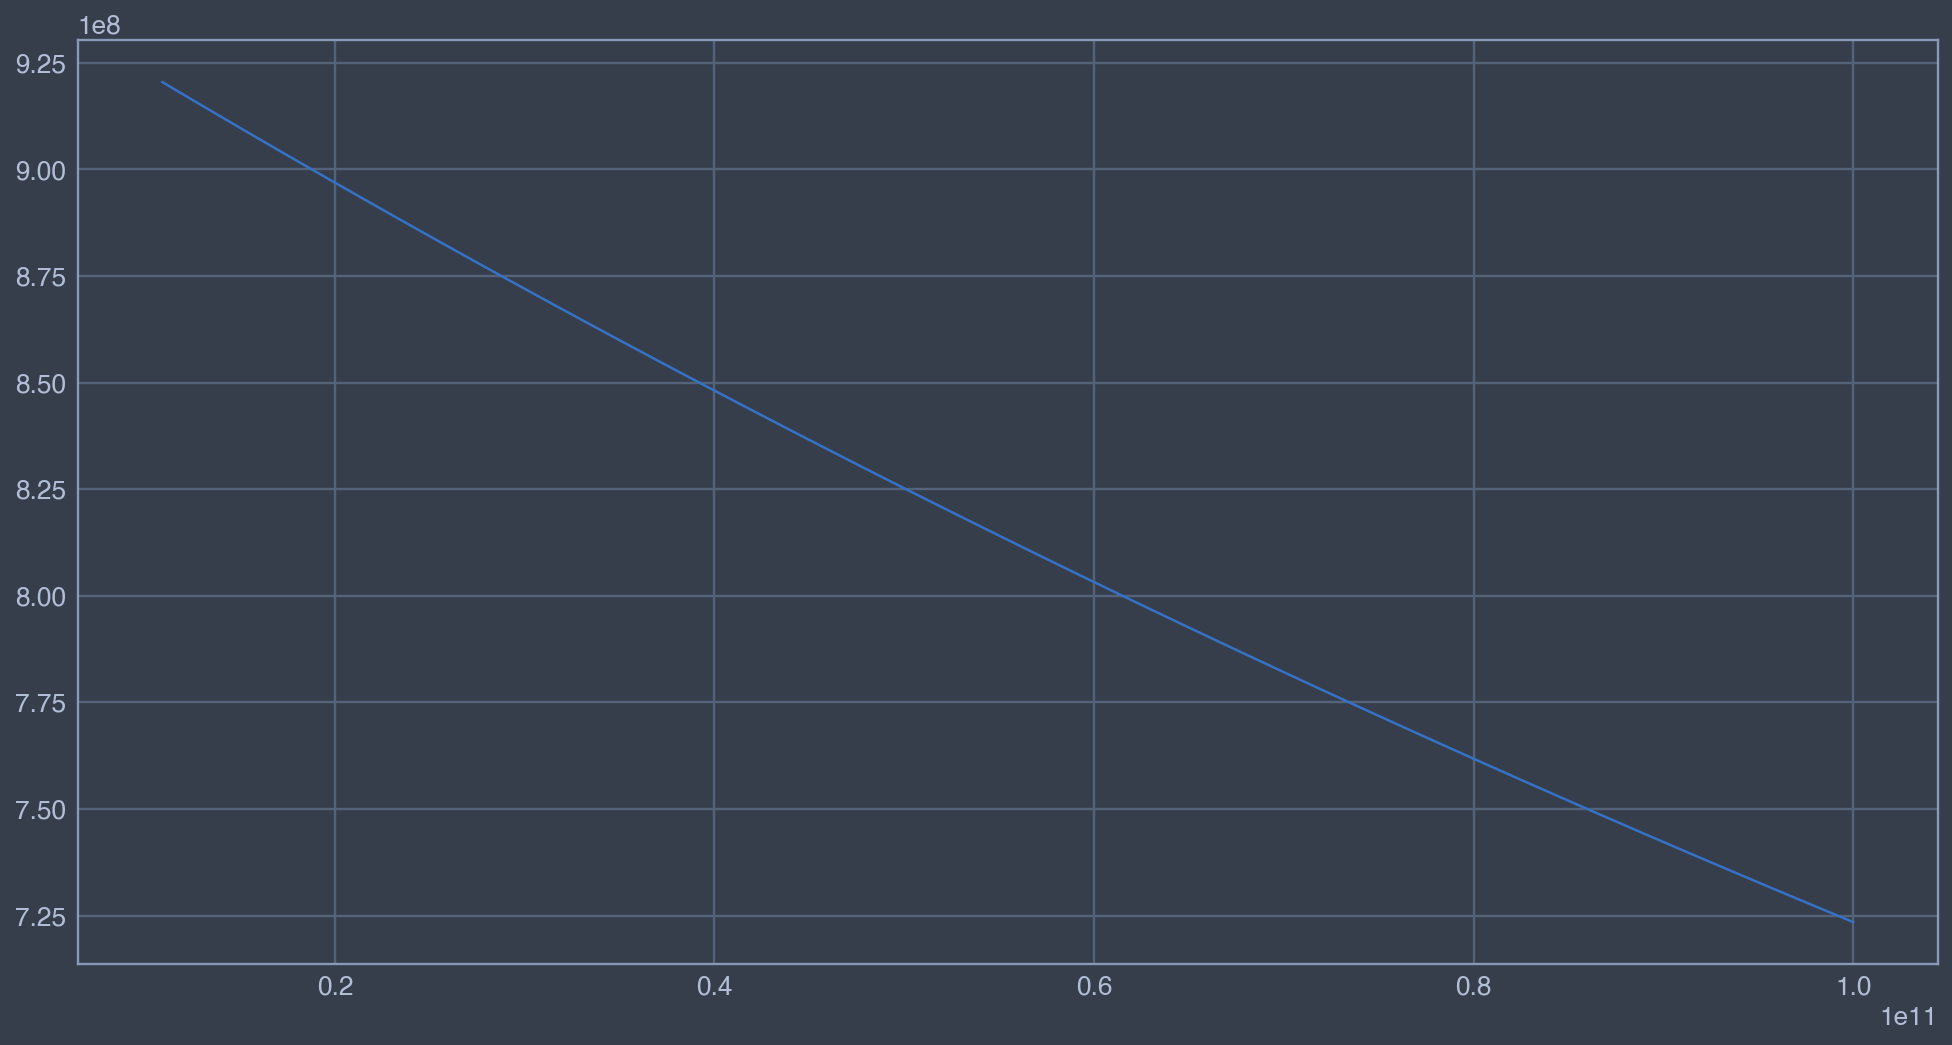

In [90]:
import matplotlib.pyplot as plt
plt.plot(amount_ins[1:], np.diff(np.array(amount_outs)))

# 3. Risks

In [138]:
import requests as req
import datetime

def get_pool_trades(pool):
    url = f'https://api.dedust.io/v2/pools/{pool}/trades'
    params = {'page_size': 500}
    data = req.get(url, params=params).json()
    amount_ins = np.array([int(x['amountIn']) for x in data])
    amount_outs = np.array([int(x['amountOut']) for x in data])
    traders = np.unique(np.array([x['sender'] for x in data]))
    times = np.array([datetime.datetime.strptime(x['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ') for x in data])
    times = np.sort(times)
    number_of_trades = len(data)
    return amount_ins, amount_outs, traders, times, number_of_trades

def pool_stats(pool):
    amount_ins, amount_outs, traders, times, number_of_trades = get_pool_trades(pool)
    mean_in = np.mean(amount_ins)
    mean_out = np.mean(amount_outs)
    std_in = np.std(amount_ins)
    std_out = np.std(amount_outs)
    unique_traders = len(traders)

    period = (times[-1] - times[0]).seconds
    if period == 0: period = 1

    tx_per_day = number_of_trades / period
    return mean_in, mean_out, std_in, std_out, unique_traders, tx_per_day, number_of_trades

In [134]:
pool = 'EQCEho8oSvzVneM-q3ALV9GMOoRzlGNwrGtq4p2x3SnInMVA'
url = f'https://api.dedust.io/v2/pools/{pool}/trades'
params = {'page_size': 500}
data = req.get(url, params=params).json()

In [136]:
tokens = ['native', 'EQD26zcd6Cqpz7WyLKVH8x_cD6D7tBrom6hKcycv8L8hV0GP', 'EQA3BC27XNeinlQFvvQQipMEoTLupUshAkSVb0W129TH_OIf', 'native']
pools = ['EQCEho8oSvzVneM-q3ALV9GMOoRzlGNwrGtq4p2x3SnInMVA', 'EQAkZmvp_rqMSeorfLHlYY_0KZzGIJKnsVXtgGmHLSgfICDu','EQCUxGimTGzseU5MEE8FUOz-mbIXNvjcO0K6-0GJfbOGRKCJ']
         


In [139]:
for pool in pools:
    mean_in, mean_out, std_in, std_out, unique_traders, tx_per_day, number_of_trades = pool_stats(pool)
    print(f'Pool: {pool}')
    print(f'Mean in: {mean_in}')
    print(f'Mean out: {mean_out}')
    print(f'Std in: {std_in}')
    print(f'Std out: {std_out}')
    print(f'Unique traders: {unique_traders}')
    print(f'Tx per sec: {tx_per_day}')
    print(f'Number of trades: {number_of_trades}')
    print('')

Pool: EQCEho8oSvzVneM-q3ALV9GMOoRzlGNwrGtq4p2x3SnInMVA
Mean in: 406408672509.706
Mean out: 325999893711.726
Std in: 1593678621035.0378
Std out: 799645964221.9617
Unique traders: 263
Tx per sec: 0.03441393075917131
Number of trades: 500

Pool: EQAkZmvp_rqMSeorfLHlYY_0KZzGIJKnsVXtgGmHLSgfICDu
Mean in: 2584434314731.908
Mean out: 1674707937721.254
Std in: 5279277601233.768
Std out: 9428272647682.717
Unique traders: 248
Tx per sec: 0.00624875024995001
Number of trades: 500

Pool: EQCUxGimTGzseU5MEE8FUOz-mbIXNvjcO0K6-0GJfbOGRKCJ
Mean in: 2124815112569.668
Mean out: 1871293735077.558
Std in: 6740525519089.8125
Std out: 4942430454725.293
Unique traders: 207
Tx per sec: 0.027613630087811345
Number of trades: 500

